In [155]:
import os
import numpy as np
import scipy.optimize as so
import matplotlib.pyplot as plt
plt.clf()
plt.close('all')
plt.style.use('classic')
import csv
from google_drive_downloader import GoogleDriveDownloader as gdd # downloads from google drive
import ROOT as r
%jsroot on

In [156]:
# FILE TO BE ANALYZED #
date = "20220428/"
fileName = "60Co_CLYC_PD"

In [157]:
data_dir = "data/" # not to be changed
analysis_dir = "analysis/" # not be changed

output = "./" + data_dir + date + fileName + ".root"

if (date + fileName == "20220428/60Co_CLYC_ML"):
    gdd.download_file_from_google_drive(file_id='1NOuMLVx_2cE8S4tgEioj7NgYsR4U-0A9', dest_path = output)

if (date + fileName == "20220428/60Co_CLYC_PD"):
    gdd.download_file_from_google_drive(file_id='1pxm0QwJ7JLtx5nOAGVovZgyxc-IHZ2UO', dest_path = output)
if (date + fileName == "20220428/133Ba_CLYC_PD"):
    gdd.download_file_from_google_drive(file_id='1eeb_2Fe0rorJxyf2D8vXZBdU6n8Jb9nE', dest_path = output)
if (date + fileName == "20220428/22Na_CLYC_PD"):
    gdd.download_file_from_google_drive(file_id='17T_Iko2GcZs7_YgzZ9XqYN0ba5fmBOXi', dest_path = output)
if (date + fileName == "20220428/137Cs_CLYC_PD"):
    gdd.download_file_from_google_drive(file_id='1MtS7CPTwx-JAOMH8ApXoAifCuWIIYn4D', dest_path = output)

In [158]:
def resolution_fit(E, a, b):
    return a / np.sqrt(E) + b
    
def linear(x, a, b):
    return a + b * x
    
def inv_linear(y, a, b): # invert the linear for y = a + b * x
    return (y - a) / b

In [159]:
bins = 8192
xMin, xMax = 400, 1800
f = r.TFile(output)
tree = f.Get("Data_F;1")
h = r.TH1I("hist", "", bins, 0, bins)

for entry in tree:         
     # Now you have acess to the leaves/branches of each entry in the tree, e.g.
     events = entry.Energy
     # timestamp = entry.Timestamp
     h.Fill(events)
h.Rebin(4)
h.GetXaxis().SetRangeUser(xMin, xMax)

In [160]:
c1 = r.TCanvas("c1", "", 800, 600)
h.Draw()
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [161]:
if "60Co" in fileName:
    xval = [1172, 1332]
if "133Ba" in fileName:
    xval = [276.4, 302.85, 356.02, 383.8]
if "22Na" in fileName:
    xval = [511, 1275]
if "137Cs" in fileName:
    xval = [662]

npeaks = len(xval)
resolution = np.zeros(npeaks)
mean = np.zeros(npeaks)
sigma = np.zeros(npeaks)
umean = np.zeros(npeaks)
usigma = np.zeros(npeaks)

In [162]:
ss = r.TSpectrum(npeaks)
nfound = ss.Search(h, 10, "new", 0.1)
print("\n --------- Found ", nfound, " peaks ---------")
xpeaks = ss.GetPositionX()


 --------- Found  2  peaks ---------


Warning in <TSpectrum::SearchHighRes>: Peak buffer full


In [163]:
for i in range(npeaks):
    xp = xpeaks[i]
    print(" ************ Peak at: ", xp, "\n")
    fun1 = r.TF1("fun1name", "gaus", xp - 30, xp + 30)
    h.Fit(fun1,"RQN")
    fun2 = r.TF1("fun2name", "gaus", fun1.GetParameter(1) - 1.5 * fun1.GetParameter(2), fun1.GetParameter(1) + 1.5 * fun1.GetParameter(2))
    h.Fit(fun2, "R+")
    mean[i] = fun2.GetParameter(1)
    sigma[i] = fun2.GetParameter(2)
    umean[i] = fun2.GetParErrors()[1]
    usigma[i] = fun2.GetParErrors()[2]

    resolution[i]=((2.35 * sigma[i]) / mean[i]) * 100;
    print("\nRESULTS:  Mean at: ", mean[i], " with sigma ", sigma[i], ", FWHM of ", 2.35 * sigma[i], ", and resolution of ", resolution[i], " %\n")

 ************ Peak at:  1382.0 


RESULTS:  Mean at:  1382.5960532133765  with sigma  23.187880352763614 , FWHM of  54.491518828994494 , and resolution of  3.9412465197153863  %

 ************ Peak at:  1578.0 


RESULTS:  Mean at:  1576.3305956928568  with sigma  23.694266000929385 , FWHM of  55.68152510218406 , and resolution of  3.532350717186323  %

 FCN=18.0726 FROM MIGRAD    STATUS=CONVERGED      71 CALLS          72 TOTAL
                     EDM=3.56629e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   3.1 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.57147e+03   2.00062e+01   2.70278e-02  -3.69851e-06
   2  Mean         1.38260e+03   1.77351e-01   7.08795e-05  -1.78742e-04
   3  Sigma        2.31879e+01   2.35169e-01  -4.67533e-06   1.12391e-02
 FCN=4.71708 FROM MIGRAD    STATUS=CONVERGED      78 CALLS          79 TOTAL
                     EDM=2.69197e-

In [164]:
sol = so.curve_fit(resolution_fit, xval, resolution, sigma = 2.35 * usigma / mean, absolute_sigma = True, maxfev = 300)
coef, cov = sol
a, b = coef; ua, ub = np.sqrt(np.diag(cov))

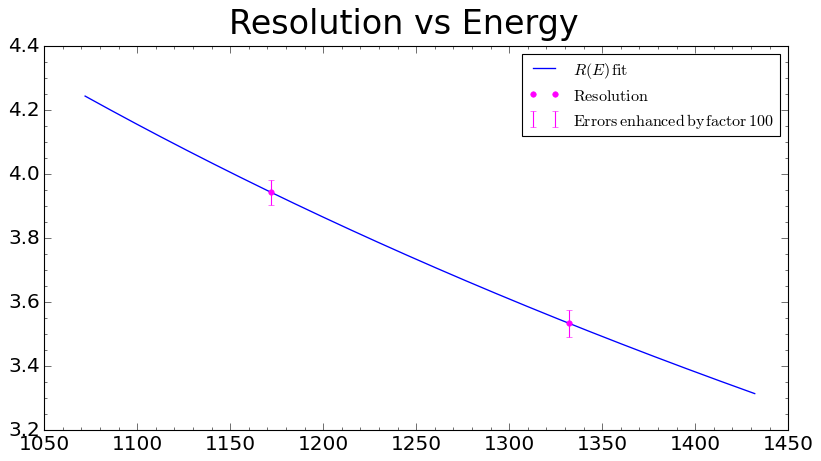

In [166]:
fig, ax = plt.subplots(); fig.patch.set_facecolor('xkcd:white')
plt.rcParams['figure.figsize'] = [12, 6]
plt.suptitle("Resolution vs Energy", fontsize = 30)
ax.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax.minorticks_on()
ax.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax.tick_params(axis = 'both', labelsize = 18)

enh_errors = 100
xaux = np.linspace(xval[0] - 100, xval[-1] + 100, 1000)
ax.plot(xaux, resolution_fit(xaux, *coef), color = 'blue', linewidth = 1.2, linestyle = 'solid', label = '$R(E)\, {\\rm fit}$')
ax.plot(xval, resolution, marker = 'o', markersize = 5, markeredgecolor = "magenta", color = "magenta", lw = 0, label = "${\\rm Resolution}$")
ax.errorbar(xval, resolution, yerr = 100 * 2.35 * usigma / mean, capsize = 3., elinewidth = 1., lw = 0, color = "magenta", label = "${\\rm Errors\, enhanced\, by\, factor}\, %i$" % enh_errors)
ax.legend(loc = "best")


In [167]:
res_at_one25 = resolution_fit(1250., *coef)
print("\n ************** RESOLUTION @ 1.25 MeV:  ", res_at_one25, "% ************** \n")


 ************** RESOLUTION @ 1.25 MeV:   3.732100883510315 % ************** 



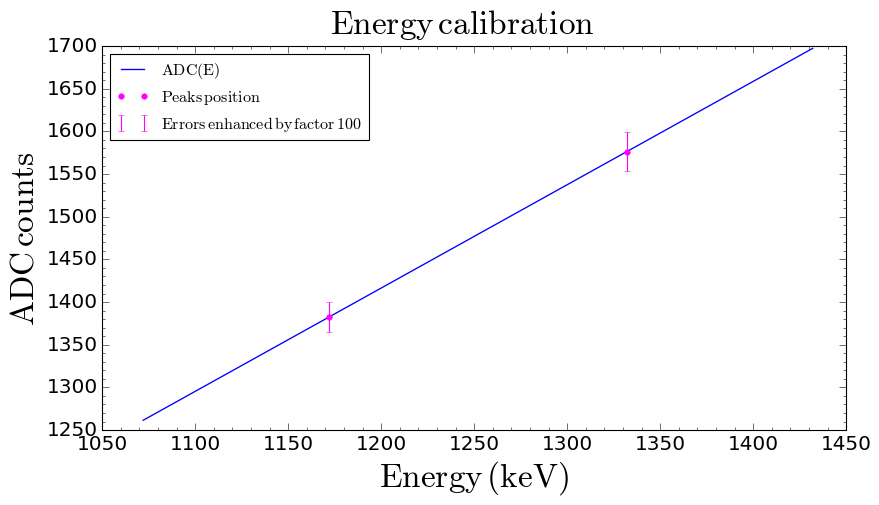

In [168]:
fig, ax = plt.subplots(); fig.patch.set_facecolor('xkcd:white')
plt.rcParams['figure.figsize'] = [12, 6]
plt.suptitle("${\\rm Energy\, calibration}$", fontsize = 30)
ax.tick_params(which = 'both', axis = 'both', direction='in', right = True, top = True, length = 6)
ax.minorticks_on()
ax.tick_params(which = 'minor', axis = 'both', direction='in', right = True, top = True, length = 3)
ax.tick_params(axis = 'both', labelsize = 18)
ax.set_xlabel("${\\rm Energy\, (\mathrm{keV})}$", fontsize = 30)
ax.set_ylabel("${\\rm ADC\, counts}$", fontsize = 30)

sol = so.curve_fit(linear, xval, mean, sigma = sigma, absolute_sigma = True)
coef, cov = sol
a, b = coef; ua, ub = np.sqrt(np.diag(cov))

enh_errors = 100
ax.plot(xaux, linear(xaux, *coef), color = 'blue', linewidth = 1.2, linestyle = 'solid', label = '${\\rm ADC(E)}$')
ax.plot(xval, mean, marker = 'o', markersize = 5, markeredgecolor = "magenta", color = "magenta", lw = 0, label = "${\\rm Peaks\, position}$")
ax.errorbar(xval, mean, yerr = enh_errors * umean, capsize = 3., elinewidth = 1., lw = 0, color = "magenta", label = "${\\rm Errors\, enhanced\, by\, factor}\, %i$" % enh_errors)
ax.legend(loc = "best")


In [169]:
hcal = r.TH1I("hist_cal", "Calibrated spectrum", bins, 0, bins)

for entry in tree:         
     hcal.Fill(inv_linear(entry.Energy, *coef))
hcal.Rebin(4)

hcal.GetXaxis().SetRangeUser(inv_linear(xMin, *coef), inv_linear(xMax, *coef))
hcal.GetXaxis().SetTitle("Photon energy [keV]");
hcal.GetYaxis().SetTitle("counts / %1.2f keV" % hcal.GetXaxis().GetBinWidth(0))

In [170]:
c2 = r.TCanvas("c2", "", 800, 600)
hcal.Draw()
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


In [171]:
try:
    os.makedirs(analysis_dir + date)
except FileExistsError:
    # directory already exists
    pass

with open(analysis_dir + date + fileName + "_cal.csv", 'w') as f:
    for i in range(npeaks):
        f.write(",%i peak" % xval[i])
    f.write("\n")
    f.write("Resolution (per cent)")
    for i in range(npeaks):
        f.write(",%.3f" % resolution[i])
f.close()

In [172]:
os.remove(output) # deleting the file once we have done the analysis